In [1]:
# from IPython.display import display, HTML
# from IPython.display import display, HTML
# from ipywidgets import interact, widgets
# %matplotlib notebook

import os
if os.name != 'posix':
    %matplotlib ipympl
else:
    %matplotlib notebook

import scipy.constants as sc
from scipy.optimize import fsolve

import numpy as np
import cmath
import matplotlib.pyplot as plt
import scipy.constants as sc
plt.rcParams.update({
    "text.usetex": True,
    'text.latex.preamble': r"\usepackage{amsmath} \boldmath"
})
import os
import h5py


# import matplotlib as mpl
# mpl.rcParams.update(mpl.rcParamsDefault)


print(os.getpid())
%cd ../../

import pylib.mix as mix

26044
C:\Users\ivan9\Documents\work\codes\QuCF\scripts-py


In [2]:
# --- Launch to change cells' width ---
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from numba import njit
import time
from matplotlib import ticker

cmap_two_signs_= 'coolwarm'
cmap_two_signs_= 'Blues'
# cmap_two_signs_= 'Greys'
# cmap_two_signs_= 'Pastel1'
# cmap_two_signs_= 'flag'
# cmap_two_signs_= 'nipy_spectral'
# cmap_two_signs_= 'jet'
# cmap_two_signs_= 'seismic'
def fmt_(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

In [3]:
# ---------------------------------------------------------------------------------------------------
# --- Consider the Lotka-Volterra prey-predator model:
# --- d x / d t =  wx*x - gx*x*y = Fx ---
# --- d y / d t = -wy*y + gy*x*y = Fy ---
# ---------------------------------------------------------------------------------------------------
mix.reload_module(mix)

nt = 9
Nt = 1 << nt
t_end = 10
t_array = np.linspace(0, t_end, Nt)
dt = np.diff(t_array)[0]

x0, y0 = 0.5, 0.5
wx, wy, gx, gy = 1, 1.2, 2, 2.1

Fx = lambda x, y:  wx*x - gx*x*y
Fy = lambda x, y: -wy*y + gy*x*y

In [4]:
# ---------------------------------------------------------------------------------------------------
# --- Direct solver:
# ---------------------------------------------------------------------------------------------------
mix.reload_module(mix)

class DirectSolver__:
    xt_ = None
    yt_ = None
    Nt_ = None
    dt_ = None
    Fx_ = None
    Fy_ = None
    t_ = None
    def __init__(self, x0, y0, Fx, Fy, t):
        self.t_ = np.array(t)
        self.Nt_ = len(self.t_)
        self.dt_ = np.diff(self.t_)[0]
        self.Fx_ = Fx
        self.Fy_ = Fy
        self.xt_ = np.zeros(self.Nt_, dtype=float)
        self.yt_ = np.zeros(self.Nt_, dtype=float)
        self.xt_[0] = x0
        self.yt_[0] = y0
        return

    def solve(self):
        for it in range(Nt-1):
            self.xt_[it+1] = self.xt_[it] + self.dt_ * self.Fx_(self.xt_[it], self.yt_[it])
            self.yt_[it+1] = self.yt_[it] + self.dt_ * self.Fy_(self.xt_[it], self.yt_[it])
        return
        

ds = DirectSolver__(x0, y0, Fx, Fy, t_array)    
ds.solve()

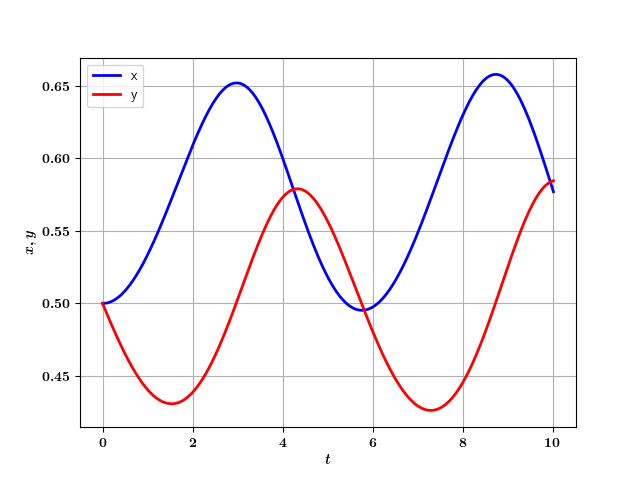

In [5]:
# --- Plot results from the direct solver ---
plt.close()
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(ds.t_, ds.xt_, color='b', linewidth = 2, linestyle='-', label="x")
ax.plot(ds.t_, ds.yt_, color='r', linewidth = 2, linestyle='-', label="y")
plt.xlabel('$t$')
plt.ylabel("$x,y$")
ax.legend()
plt.grid(True)
plt.show()

In [8]:
# ---------------------------------------------------------------------------------------------------
# --- KvN solver:
# ---------------------------------------------------------------------------------------------------
class KvN__:
    psi_ = None
    nx_, ny_ = None, None
    Nx_, Ny_ = None, None # the number of points to describe a single variable;
    t_ = None
    delta_x_, delta_y_ = None, None
    x0_, y0_ = None, None
    x_, y_ = None, None
    dx_, dy_ = None, None
    wx_, wy_, gx_, gy_ = None, None, None, None

    def __init__(self, x0, y0, t):
        # time grid
        self.t_ = np.array(t)
    
        # grids for the variables:
        self.nx_, self.ny_ = 7, 7
        self.Nx_ = 1 << self.nx_
        self.Ny_ = 1 << self.ny_
        max_r = 2.0
        self.x_ = np.array(np.linspace(-max_r, max_r, self.Nx_), dtype='float32')
        self.y_ = np.array(np.linspace(-max_r, max_r, self.Ny_), dtype='float32')
        self.dx_ = np.diff(self.x_)[0]
        self.dy_ = np.diff(self.y_)[0]
    
        # state vector:
        self.psi_ = np.zeros((Nt, self.Nx_, self.Ny_), dtype='float32')
    
        # Initial state parameters:
        self.delta_x_ = 0.05
        self.delta_y_ = 0.05
        self.x0_ = x0
        self.y0_ = y0
        
        coef_gauss = 1./(2.*np.pi * self.delta_x_ * self.delta_y_)
        for iy in range(self.Ny_):
            for ix in range(self.Nx_):
                temp  = np.exp(-(self.x_[ix] - self.x0_)**2/(2.*self.delta_x_**2))
                temp *= np.exp(-(self.y_[iy] - self.y0_)**2/(2.*self.delta_y_**2)) * temp
                self.psi_[0, ix, iy] = temp
        self.psi_ = np.sqrt(coef_gauss * self.psi_)
        self.psi_[0,         0, :] = 0.0
        self.psi_[0, self.Nx_-1, :] = 0.0
        self.psi_[0,          :,          0] = 0.0
        self.psi_[0,          :, self.Ny_-1] = 0.0
    
# -----------------------------------
st = time.time()

kvn = KvN__(x0, y0, t_array)

et = time.time()
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

# %time kvn = KvN__(x0, y0, t_array, wx, wy, gx, gy)

Execution time: 0.08594274520874023 seconds


In [9]:
# Compute the KvN:
@njit
def solve_KvN(
    psi, 
    wx, wy, gx, gy, 
    Nt, dt, 
    x, y, 
    Nx, Ny, 
    dx, dy
): 
    # we use Dirichlet boundary conditions:
    for it in range(Nt-1):
        for iy in range(1, Ny-1):
            y1 = y[iy] 
            for ix in range(1, Nx-1):
                x1 = x[ix]
                
                psi1     = psi[it, ix,   iy]
                psi1_x_p = psi[it, ix+1, iy]
                psi1_y_p = psi[it, ix,   iy+1]
                psi1_x_m = psi[it, ix-1, iy]
                psi1_y_m = psi[it, ix,   iy-1]

                Fx1 =  wx*x1 - gx*x1*y1
                Fy1 = -wy*y1 + gy*x1*y1

                if Fx1 < 0:
                    diff_x = (psi1_x_p - psi1) / dx
                else:
                    diff_x = (psi1 - psi1_x_m) / dx

                if Fy1 < 0:
                    diff_y = (psi1_y_p - psi1) / dy
                else:
                    diff_y = (psi1 - psi1_y_m) / dy

                temp = -0.5 * psi1 * (wx - wy + gy*x1 - gx*y1)
                temp -= (Fx1 * diff_x + Fy1 * diff_y) 

                psi[it+1, ix, iy] = psi1 + dt * temp

# -------------------------------------------
st = time.time()

solve_KvN(
    kvn.psi_[:,:,::1], 
    wx, wy, gx, gy, 
    len(kvn.t_), np.diff(kvn.t_)[0],
    kvn.x_,  kvn.y_,
    kvn.Nx_, kvn.Ny_,
    kvn.dx_, kvn.dy_
)

et = time.time()
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

Execution time: 0.4921293258666992 seconds


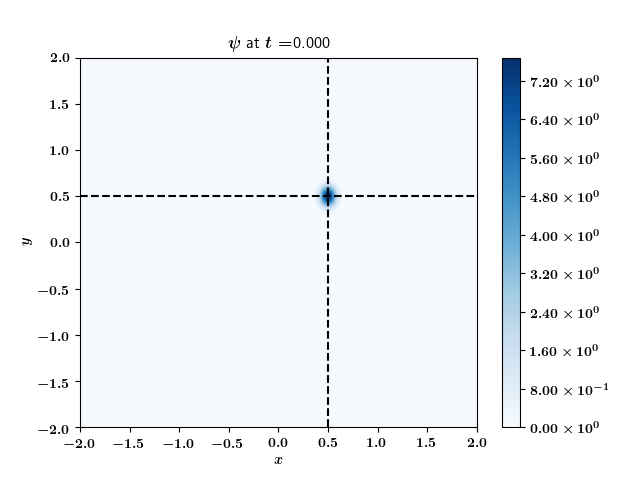

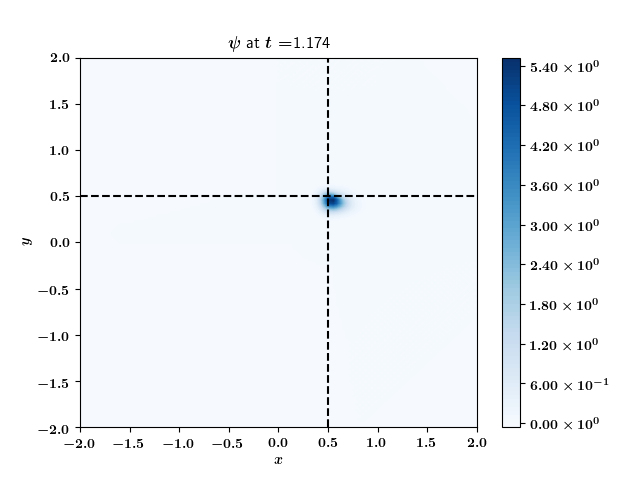

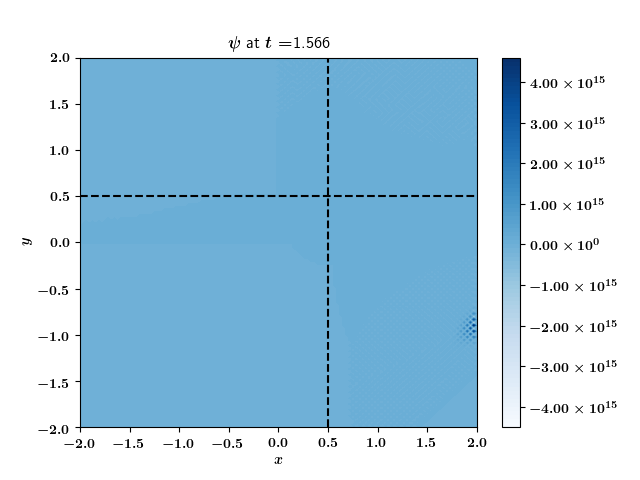

In [11]:
# ---------------------------------------------------------------------------------------------------
# --- Print psi(x, y) at different t ---
# ---------------------------------------------------------------------------------------------------

# id_ts = [0,10,20]
# id_ts = [10,12,15]
id_ts = [0, 60, 80]

XX, YY = np.meshgrid(kvn.x_, kvn.y_)
plt.close()

for id_t in id_ts:
    fig_xy = plt.figure()
    ax = fig_xy.add_subplot(111)
    cs = ax.contourf(XX, YY, np.transpose(kvn.psi_[id_t, :, :]), levels=100, cmap=cmap_two_signs_)
    fig_xy.colorbar(cs, ax = ax, format=ticker.FuncFormatter(fmt_))
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_title('$\psi$ at $t = $' + '{:0.3f}'.format(kvn.t_[id_t]))
    # ax.set_ylim(0.0, 1.5)
    
    plt.vlines(kvn.x0_, ax.get_ylim()[0], ax.get_ylim()[1], "black", linestyle="--")
    plt.hlines(kvn.y0_, ax.get_xlim()[0], ax.get_xlim()[1], "black", linestyle="--")



# id_t = 20
# fig_xy = plt.figure()
# ax = fig_xy.add_subplot(111)
# cs = ax.contourf(XX, YY, np.transpose(kvn.psi_[id_t, :, :]), levels=100, cmap=cmap_two_signs_)
# fig_xy.colorbar(cs, ax = ax, format=ticker.FuncFormatter(fmt_))
# ax.set_xlabel('$x$')
# ax.set_ylabel('$y$')
# ax.set_title('$\psi$ at $t = $' + '{:0.3f}'.format(kvn.t_[id_t]))
# # ax.set_ylim(0.0, 1.5)

# plt.vlines(kvn.x0_, ax.get_ylim()[0], ax.get_ylim()[1], "black", linestyle="--")
# plt.hlines(kvn.y0_, ax.get_xlim()[0], ax.get_xlim()[1], "black", linestyle="--")

# find averaged x-profile along y:



del id_t, fig_xy, ax